# Training model on full dataset

## Imports

In [1]:
# connecting drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

from datetime import date
import torchvision
import numpy as np
import torch
import argparse
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import torch.nn as nn
from collections import OrderedDict
import torch.optim as optim
import time
import copy
import torchvision.transforms as transforms
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import matplotlib.pyplot as plt

import sys
sys.path.append('/content/drive/My Drive/drive_folder')
from custom_dataset_loader import TaiChiDataset, ToTensor, Normalize
from helper_functions import set_parameter_requires_grad, meshgrid2d, get_grid, plot_learning_curve, split_dataset, initialise_model, get_predictions, zero_out_coords, show_predictions


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper functions

In [2]:
def show_predictions(pred_coords, pred_vis, true_coords, true_vis, zeroed=False, num_samples=3):
  batch_size = pred_coords.shape[0]

  # sample some samples at random
  sample_ids = np.random.choice(batch_size, num_samples)

  for x in sample_ids:
    pred_c = pred_coords[x, :, :, :].cpu().detach().numpy().squeeze()
    pred_v = pred_vis[x, :, :].cpu().detach().numpy().squeeze()
    true_c = true_coords[x, :, :, :].cpu().numpy().squeeze()
    true_v = true_vis[x, :, :].cpu().numpy().squeeze()
    
    pred_v = pred_v <= 0
    true_v = true_v <= 0
    
    # print(np.count_nonzero(true_vis))
    # print(np.count_nonzero(pred_vis))
    
    if zeroed:
      true_c[ :, 0] = np.where(true_v, 0, true_c[ :, 0])
      true_c[ :, 1] = np.where(true_v, 0, true_c[ :, 1])
      pred_c[ :, 0] = np.where(pred_v, 0, pred_c[ :, 0])
      pred_c[ :, 1] = np.where(pred_v, 0, pred_c[ :, 1])
      pred_v = true_v

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  
    ax1.scatter(true_c[:, 0], true_c[:, 1], s=0.5, marker='.', c=true_v, cmap=plt.cm.coolwarm)
    ax1.set_ylim(360, 0)
    ax1.set_title('True Coords')

    pred_x = pred_c[:, 0]
    pred_y = pred_c[:, 1]
    ax2.scatter(pred_x, pred_y, s=0.5, marker='.', c=pred_v, cmap=plt.cm.coolwarm)
    ax2.set_ylim(360, 0)
    ax2.set_title('Predicted Coords')
    
    plt.show()

In [3]:
def show_image(img):
  if torch.is_tensor(img):
    img=img.permute(1, 2, 0).numpy()
  plt.imshow(img)
  plt.show()

def show_coords(coords, vis):
  vis = vis > 0
  plt.scatter(coords[:, 0], coords[:, 1], s=0.5, marker='.', c=vis, cmap=plt.cm.coolwarm)
  plt.ylim(max(plt.ylim()), min(plt.ylim()))
  plt.pause(0.001)  # pause a bit so that plots are updated
  
def show_batch(ids_batch, img0_batch, img3_batch, coords_batch, vis_batch, img7_batch):
  for i in range(len(ids_batch)):
      print("sample id:", ids_batch[i])
      show_image(img0_batch[i])
      show_image(img3_batch[i])
      show_image(img7_batch[i])
      show_coords(coords_batch[i].squeeze(), vis_batch[i].squeeze())

## Train function

In [4]:
def train_model(model, dataloaders, criterion, vis_criterion, optimizer, past_t_loss, past_v_loss, num_epochs=10_000, verbose=False, mask=True, clip=1.0, store_val=False, eval_freq=5, plot=False):
  model.to(device)
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 0.0

  # Log loss history
  train_loss_history = past_t_loss
  val_loss_history = past_v_loss
  global_epoch = len(past_t_loss)

  train_size = len(dataloaders['train'].dataset)
  valid_size = len(dataloaders['val'].dataset)

  print("Starting training: {} epochs".format(num_epochs))
  print("Dataset size: Train-{}, Valid-{}".format(train_size, valid_size))

  if valid_size==0:
    phases = ['train']
  else:
    phases = ['train', 'val']

  for epoch in range(0,num_epochs):
    # Each epoch has a training and validation phase (only do validation each 100th epoch)
    for phase in phases:
      if phase == 'train':
        model.train() # Set model to training mode
      elif phase == 'val' and (epoch%eval_freq==0 or epoch == num_epochs-1):
        model.eval() # Set model to evaluate mode
      else:
        continue
        
      running_loss = 0.0
      running_vis_loss = 0.0
      running_coords_loss = 0.0
      total_samples = 0

      # Iterate over data.
      for i_batch, sample_batched in enumerate(dataloaders[phase]):
        batch_size = len(sample_batched['id'])
        total_samples+=batch_size
              
        # Get input images and concatenate image tensors on channel dimension
        input1 = sample_batched['image0']
        input2 = sample_batched['image3']
        inputs = torch.cat((input1, input2), dim=1) 

        # Get ground truth coords and vis
        coords = sample_batched['coords']
        vis = torch.where(sample_batched['vis'] > 0, 1.0, 0.0)
              
        inputs = inputs.to(device).float() # torch.Size([B, 6, H, W])
        coords = coords.to(device) # torch.Size([B, 1, 4096, 2])
        vis = vis.to(device) # torch.Size([B, 1, 4096])

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward and track history
        with torch.set_grad_enabled(phase == 'train'):

          # Get model outputs 
          outputs = model(inputs) # torch.Size([B, 3, H, W]) same as inputs shape
          outputs = outputs['out']
          outputs_coords, outputs_vis = get_predictions(outputs, coords, batch_size) # pre-processing of outputs

          # Zero out those in both outputs_coords and coords so they dont contribute to coords_loss
          outputs_coords_zeroed, coords_zeroed = zero_out_coords(coords, outputs_coords, vis)

          # Calculate loss
          sigmoid = nn.Sigmoid()
          vis_loss = (vis_criterion(sigmoid(outputs_vis), vis))/ 0.7
          if mask:
            coords_loss = (criterion(outputs_coords_zeroed, coords_zeroed))/20
          else:
            coords_loss = (criterion(outputs_coords, coords))/20
          loss = coords_loss + vis_loss
                    

          # Backward + optimize only in train phase
          if phase == 'train':
            loss.backward()

            # Gradient Norm/Value Clipping
            #nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            nn.utils.clip_grad_value_(model.parameters(), clip_value=clip)

            optimizer.step()

          # Statistics
          running_loss += loss.item() * inputs.size(0)
          running_vis_loss += vis_loss.item() * inputs.size(0)
          running_coords_loss += coords_loss.item() * inputs.size(0)

      
      epoch_loss = running_loss/total_samples
      epoch_vis_loss = running_vis_loss/total_samples
      epoch_coords_loss = running_coords_loss/total_samples

      # Log losses to train/val loss history
      if phase == 'train':
        train_loss_history.append((global_epoch+epoch, epoch_loss, epoch_coords_loss, epoch_vis_loss))
      if phase == 'val':
        val_loss_history.append((global_epoch+epoch, epoch_loss, epoch_coords_loss, epoch_vis_loss))
        # Deep copy the best validation model
        if epoch==0:
          best_loss = epoch_loss
        if epoch_loss < best_loss:
          best_loss = epoch_loss
          best_model_wts = copy.deepcopy(model.state_dict())

        # Store the model checkpont
        save_checkpoint(model, best_model_wts, train_loss_history, val_loss_history, optimizer)

    # Report on losses of the model
    if verbose:
      print('-' * 50)
      print('Epoch {}/{}'.format(global_epoch+epoch, global_epoch+(num_epochs - 1)))
      print('Train Loss: {:.4f} ({:.4f} coords loss, {:.4f} vis loss) '.format(train_loss_history[-1][1], train_loss_history[-1][2], train_loss_history[-1][3]))
      if val_loss_history:                
        print('Valid Loss: {:.4f} ({:.4f} coords loss, {:.4f} vis loss) '.format(val_loss_history[-1][1], val_loss_history[-1][2], val_loss_history[-1][3])) 
      time_elapsed = time.time() - since
      print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

      # if plot and epoch !=0:
      #   # Plot recent learning curve
      #   plot_learning_curve(train_loss_history[-5:], val_loss_history[-(5//eval_freq+1):])
      #   # Show some random predictions from val mode
      #   show_predictions(outputs_coords, outputs_vis, coords, vis, zeroed=False, num_samples=1)
              
  time_elapsed = time.time() - since
  print('-' * 50)
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Final Train Loss: {:4f}\n'.format(train_loss_history[-1][1]))
  print('Best Valid Loss: {:4f}\n'.format(best_loss))
  print('-' * 50)

  # Storing best validation model weights or final training weights
  if store_val:
    model.load_state_dict(best_model_wts)
  else:
    final_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(final_model_wts)

  # Plot learning curve
  plot_learning_curve(train_loss_history, val_loss_history)

  # Show some final random predictions
  show_predictions(outputs_coords, outputs_vis, coords, vis, zeroed=True, num_samples=5)
  
  return model, train_loss_history, val_loss_history

In [5]:
from datetime import datetime
import shutil


def save_checkpoint(model, best_weights, train_loss, valid_loss, optimizer):
  checkpoint = {'description': 'training full model',
              'train_loss_history': train_loss,
              'val_loss_history': valid_loss,
              'params_to_learn': ["all"],
              'batch_size': B,
              'learning_rate': LR,
              'momentum': M,
              'optimizer': my_optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'best weights': best_weights}
  
  TODAY = date.today()
  TIME = datetime.now().strftime("%X")
  FILENAME = 'checkpoint_'+str(TODAY)+'_'+str(TIME)+'.pth'
  torch.save(checkpoint, FILENAME)
  shutil.copyfile("/content/"+FILENAME, "/content/drive/MyDrive/checkpoints/"+FILENAME)

## Load dataset

In [6]:
# Load dataset
TRAIN_DATA = "full_dataset_train_2023-02-19"
# !unzip -d "$TRAIN_DATA"/ /content/drive/MyDrive/"$TRAIN_DATA".zip # unziping training data

VALID_DATA = "full_dataset_valid_2023-02-19"
# !unzip -d "$VALID_DATA"/ /content/drive/MyDrive/"$VALID_DATA".zip # unziping training data

train_dataset = TaiChiDataset(log_file=TRAIN_DATA+'/sample_ids.txt',
                        root_dir=TRAIN_DATA,
                        check=True,
                        transform=transforms.Compose([ToTensor()]))

valid_dataset = TaiChiDataset(log_file=VALID_DATA+'/sample_ids.txt',
                        root_dir=VALID_DATA,
                        check=True,
                        transform=transforms.Compose([ToTensor()]))

print(len(train_dataset), len(valid_dataset))

3656 457


In [7]:
def get_dataloaders(batch_size, shuffle=True):
  train_dataloader = DataLoader(train_dataset, batch_size=14, shuffle=True, num_workers=0)
  validation_dataloader = DataLoader(valid_dataset, batch_size=14, shuffle=True, num_workers=0)
  return train_dataloader, validation_dataloader

## Load checkpoint to resume training

In [8]:
def load_checkpoint(filename):
  filepath = "/content/drive/MyDrive/checkpoints/"+filename
  checkpoint = torch.load(filepath)

  print(checkpoint['train_loss_history'])
  print(checkpoint['val_loss_history'])

  return checkpoint['state_dict'], checkpoint['train_loss_history'],  checkpoint['val_loss_history']

In [9]:
model_weights, past_t_loss, past_v_loss = load_checkpoint("checkpoint_2023-02-20_20:45:37.pth")

[(0, 3.9293044996600703, 3.690846001619322, 0.23845850747624817), (1, 3.986883075838538, 3.7503868036249273, 0.23649626811334548), (2, 3.858569475799734, 3.6240192257862383, 0.2345502428767522), (3, 3.6837329611149605, 3.449072310354569, 0.23466064859206098), (4, 3.6620000220623266, 3.428468502625921, 0.23353151051445784), (5, 3.495212377715424, 3.2649372914557384, 0.23027508081440332), (6, 3.3549541066720656, 3.12517240813055, 0.2297816969315711), (7, 3.5727205157475606, 3.339951318124191, 0.23276919812877017), (8, 3.3308256073514535, 3.1003141987832423, 0.23051141116042628), (9, 3.14564459691032, 2.9185819272726317, 0.22706267640760874)]
[(0, 4.078611864824524, 3.8291993589839475, 0.24941246051757027), (4, 3.6324101344761757, 3.3997732468715642, 0.23263693550352976), (5, 3.5769361635788264, 3.3409561703972015, 0.23597999142087522), (9, 2.9185869067711696, 2.6920349073618715, 0.226551992822789)]


## Training

Starting training: 5 epochs
Dataset size: Train-3656, Valid-457
--------------------------------------------------
Epoch 10/14
Train Loss: 2.9148 (2.6901 coords loss, 0.2247 vis loss) 
Valid Loss: 2.8784 (2.6519 coords loss, 0.2265 vis loss) 
Time elapsed: 20m 33s
--------------------------------------------------
Epoch 11/14
Train Loss: 2.9104 (2.6854 coords loss, 0.2250 vis loss) 
Valid Loss: 2.8784 (2.6519 coords loss, 0.2265 vis loss) 
Time elapsed: 39m 37s
--------------------------------------------------
Epoch 12/14
Train Loss: 2.8951 (2.6718 coords loss, 0.2233 vis loss) 
Valid Loss: 2.8784 (2.6519 coords loss, 0.2265 vis loss) 
Time elapsed: 58m 41s
--------------------------------------------------
Epoch 13/14
Train Loss: 2.7397 (2.5179 coords loss, 0.2218 vis loss) 
Valid Loss: 2.8784 (2.6519 coords loss, 0.2265 vis loss) 
Time elapsed: 77m 43s
--------------------------------------------------
Epoch 14/14
Train Loss: 2.9950 (2.7711 coords loss, 0.2239 vis loss) 
Valid Loss:

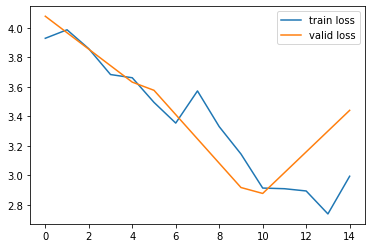

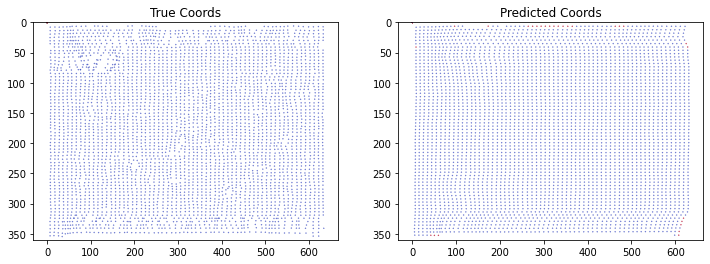

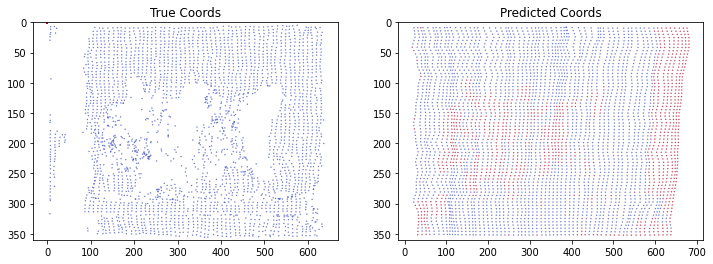

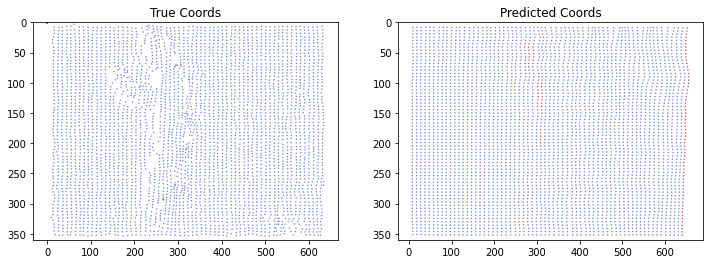

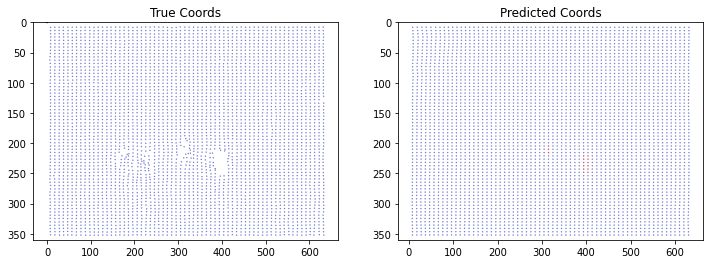

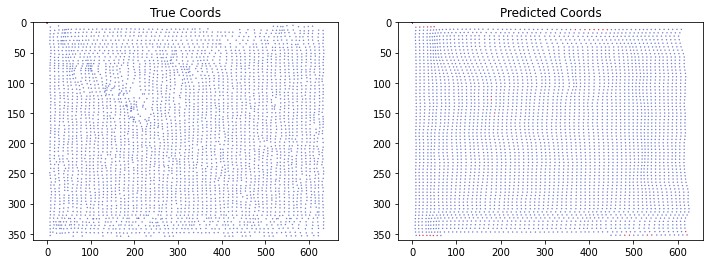

In [10]:
# Set computation device
device = torch.device('cuda')

# MODEL INITIALISATION
# possible params to_learn=[]:
#   'backbone.conv1.weight' - first layer
#   'backbone.layer1.0.conv1.weight' - second layer
#   'classifier.4.weight', 'classifier.4.bias' - last layer
#   'all' - all layers
modified_model = initialise_model(device, to_learn=['all'])
params_to_update = modified_model.parameters()
# if model_weights:
modified_model.load_state_dict(model_weights)

# DEFINE HYPERPARAMETERS
shuffle_dataset = True
random_seed = 42
B = 13 # Batch size
E = 5 # Number of epoch
C= 1.0 # Gradient lip value
eval_freq=5 # Run validation every 100th epoch

# GET DATALOADERS
train_loader, validation_loader = get_dataloaders(B, shuffle=shuffle_dataset)
dataloaders_dict = {'train': train_loader, 'val': validation_loader}

# Define optimizer
LR = 0.06 # learning rate
M = 0.9 # momentum
my_optimizer = optim.SGD(params_to_update, lr=LR, momentum=M)

# Setup the loss
my_criterion = nn.MSELoss()
my_vis_criterion = nn.BCELoss()

# TRAIN MODEL
model, model_t_loss,  model_v_loss  = train_model(modified_model,
                                                  dataloaders_dict,
                                                  my_criterion,
                                                  my_vis_criterion,
                                                  my_optimizer,
                                                  past_t_loss,
                                                  past_v_loss,
                                                  num_epochs=E,
                                                  verbose=True,
                                                  clip=C,
                                                  store_val=True,
                                                  eval_freq=5
                                                  )

## Saving model

In [28]:
save_checkpoint(model, None, past_t_loss+model_t_loss, past_v_loss+model_v_loss, my_optimizer)